In [33]:
import os
from google.colab import drive

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from PIL import Image

# Configuración de google drive

In [3]:
# Montar google drive
drive.mount('/content/drive')

# Cambiar de directorio raiz
ROOT_DIR = '/content/drive/MyDrive/skin-cancer'
os.chdir(ROOT_DIR)

Mounted at /content/drive


# Descarga de los datos Skin Cancer MNIST: HAM10000

Desde Kaggle https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000 se descarga el set de datos HAM10000, el cual consiste en una colección de 10015 imágenes dermatóstópicas de múltiples fuentes, que incluyen las lesiones cutáneas pigmentadas más comunes. Este conjunto de datos es adecuado para el entrenamiento de algoritmos de clasificación multiclase. Además, todas las lesiones han sido confirmadas por expertos.

El set de datos tiene la siguiente estructura:

```
--> HAM10000_images_part_1
--> HAM10000_images_part_2
--> HAM10000_metadata
--> hmnist_8_8_RGB
--> hmnist_28_28_RGB
--> hmnist_8_8_L
--> hmnist_28_28_L
```

# Análisis exploratorio de los metadatos

En el conjunto de datos, el archivo HAM10000_metadata.csv contiene los metadatos de cada imagen. En este apartado se realiza un análisis exploratorio de ese fichero.



In [4]:
df_metadata = pd.read_csv('/content/drive/MyDrive/skin-cancer/data/HAM10000_metadata.csv')
df_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


Los metadatos compreden 10015 entradas, cada una correspondiente a una imagen única. Se distribuye en las siguientes columnas:


1.   **lesion_id**: identificador único para cada lesión.
2.   **image_id**: identificador único para cada imagen.
3.   **dx**: tipo de lesión de la piel, que corresponde a la etiqueta de clasificación.
4.   **dx_type**: método de confirmación diagnóstica de la lesión.
5.   **age**: edad del paciente.
6.   **sex**: sexo del paciente.
7.   **localization**: localización anatómica de la lesión.

En este análisis preliminar, se han identificado las variables categóricas, ‘dx_type’, ‘sex’ y ‘localization’, y la variable numérica, ‘age’. Un detalle importante es que la variable ‘age’ tiene 57 valores perdidos.



In [6]:
(
    df_metadata.isna().sum()
)

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0


In [8]:
df_metadata.nunique()

,0
lesion_id,7470
image_id,10015
dx,7
dx_type,4
age,18
sex,3
localization,15


También se observa que una sola lesión puede tener múltiples imágenes asociadas.

## Distribución de las variables de los metadatos

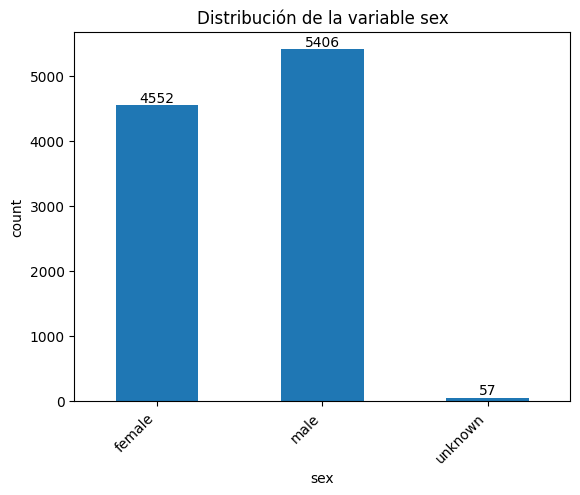

In [9]:
ax =(
    df_metadata
    .groupby('sex').size()
    .plot(kind='bar', title='Distribución de la variable sex')
)

for container in ax.containers:
    ax.bar_label(container)

plt.ylabel('count')
plt.xticks(rotation=45, ha='right');

Se observa como hay 854 casos más de lesiones en hombres que en mujeres.

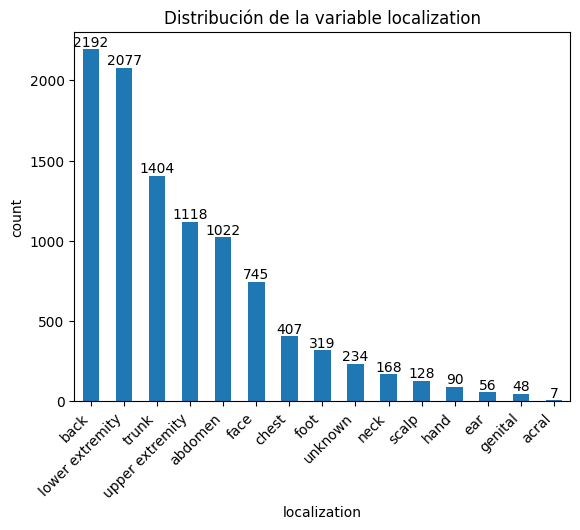

In [10]:
ax =(
    df_metadata
    .groupby('localization').size()
    .sort_values(ascending=False)
    .plot(kind='bar', title='Distribución de la variable localization')
)

for container in ax.containers:
    ax.bar_label(container)

plt.ylabel('count')
plt.xticks(rotation=45, ha='right');

La dsitribución de la variable 'localization' revela que la mayoría de las imagenes están tomadas en la espalda, las extremidades inferiores y el torso.

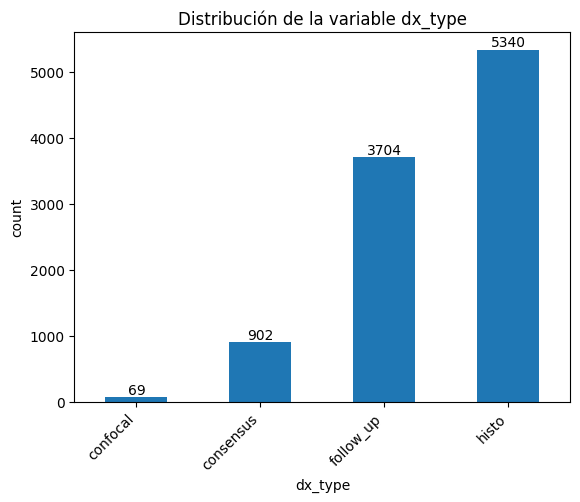

In [11]:
ax =(
    df_metadata
    .groupby('dx_type').size()
    .plot(kind='bar', title='Distribución de la variable dx_type')
)

for container in ax.containers:
    ax.bar_label(container)

plt.ylabel('count')
plt.xticks(rotation=45, ha='right');

Se observa como la mayoría de lesiones fueron confirmadas mediante histopatología (histo), seguida de exámenes de seguimiento (follow_up), consenso de expertos (consenso), y microscopía confocal in vivo (confocal).

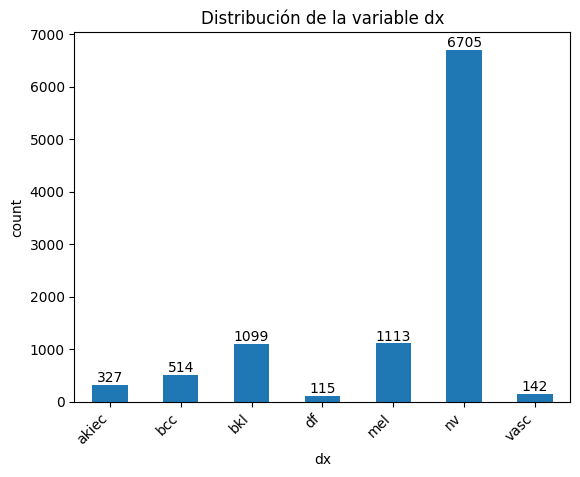

In [12]:
ax =(
    df_metadata
    .groupby('dx').size()
    .plot(kind='bar', title='Distribución de la variable dx')
)

for container in ax.containers:
    ax.bar_label(container)

plt.ylabel('count')
plt.xticks(rotation=45, ha='right');

En la distribución de la variable 'dx', se observa que  la lesión más frecuente es el ‘nevus melanocítico’ (nv) y que existe notable desbalanceo de clases. Las clases del conjunto de datos son las siguientes:

*   akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease
*   bcc: basal cell carcinoma
*   bkl: benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)
*   df: dermatofibroma
*   mel: melanoma
*   nv: melanocytic nevi
*   vasc: vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)


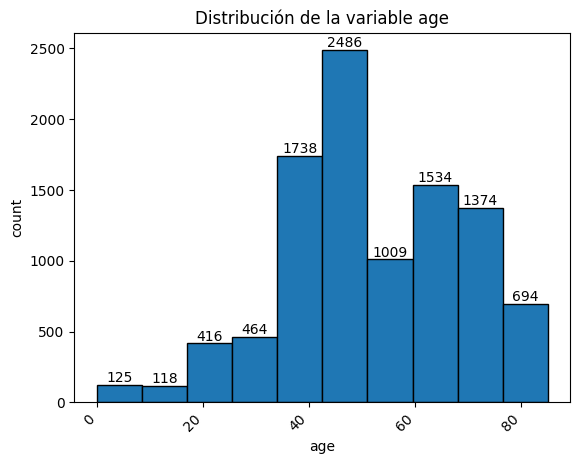

In [16]:
ax =(
    df_metadata['age']
    .plot(kind='hist', edgecolor='k', title='Distribución de la variable age')
)

for container in ax.containers:
    ax.bar_label(container)

plt.ylabel('count')
plt.xticks(rotation=45, ha='right')
plt.xlabel('age');

In [18]:
df_metadata.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


En resumen, en este análisis exploratorio se ha revelado los siguientes puntos clave:

*   La lesión más frecuente es el ‘nevus melanocítico’.
*   Existe un problema de desbalanceo de clases.
*   El método de detección más utilizado es la histopatología.
*   La edad media de los pacientes es de 51 años.
*   La mayoría de los pacientes tienen entre los 50 a 65 años.
*   La lesión que tiene más imágenes es la ‘HAM_0003789’.



## Preprocesado de los metadatos


In [17]:
#Comprobar si hay duplicados
df_metadata.duplicated().sum()

0

In [19]:
#A los valores perdidos de la variable edad, se le asigna el valor medio
df_metadata['age']= df_metadata['age'].fillna(df_metadata['age'].median())

In [20]:
#Renombrado de las columnas
df_metadata =(
    df_metadata
    .rename(columns={'dx': 'diagnosis_code', 'dx_type': 'confirmation_method', 'localization':'region_disease'})
)
df_metadata.head()

,lesion_id,image_id,diagnosis_code,confirmation_method,age,sex,region_disease
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [21]:
# Mapeo del código de diagnóstico con el nombre
diagnosis_mapping = {
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis-Like Lesions',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic Nevi'
}

# Crea la nueva columna diagnosis con el nombre de la lesión
df_metadata['diagnosis'] = df_metadata['diagnosis_code'].map(diagnosis_mapping)

In [22]:
# Convierte la columna age a entero
df_metadata['age'] = df_metadata['age'].astype(int)

In [23]:
df_metadata.head()

,lesion_id,image_id,diagnosis_code,confirmation_method,age,sex,region_disease,diagnosis
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign Keratosis-Like Lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign Keratosis-Like Lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign Keratosis-Like Lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign Keratosis-Like Lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign Keratosis-Like Lesions


Después de las operaciones anteriores de preprocesado, el último paso es incluir la ruta de la imagen dentro del dataframe de los metadatos.

Las imágenes de HAM10000 están almacenadas en dos carpetas separadas, HAM10000_images_part_1 y HAM10000_images_part_2. Con el siguiente código se ha unificado en un mismo directorio.

```
import os
import shutil

# Directorios de destino
image_path1 = os.path.join(ROOT_DIR, 'data/HAM10000_images_part_1')
image_path2 = os.path.join(ROOT_DIR, 'data/HAM10000_images_part_2')
final_image_dataset = os.path.join(ROOT_DIR, 'data/HAM10000_images_all')

# Crea el directorio de destino si no existe
if not os.path.exists(final_image_dataset):
    os.makedirs(final_image_dataset)

# Itera por las imágenes del directorio 1 y las copia en la de destino
for filename in os.listdir(image_path1):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Specify file extensions as needed
        shutil.copy(os.path.join(image_path1, filename), final_image_dataset)

# Itera por las imágenes del directorio 2 y las copia en la de destino
for filename in os.listdir(image_path2):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Specify file extensions as needed
        shutil.copy(os.path.join(image_path2, filename), final_image_dataset)
```

In [24]:
final_image_dataset = os.path.join(ROOT_DIR, 'data/HAM10000_images_all')
df_metadata['image_path'] = df_metadata['image_id'].apply(lambda x: os.path.join(final_image_dataset, f"{x}.jpg"))

In [25]:
df_metadata

,lesion_id,image_id,diagnosis_code,confirmation_method,age,sex,region_disease,diagnosis,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign Keratosis-Like Lesions,/content/drive/MyDrive/skin-cancer/data/HAM100...
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign Keratosis-Like Lesions,/content/drive/MyDrive/skin-cancer/data/HAM100...
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign Keratosis-Like Lesions,/content/drive/MyDrive/skin-cancer/data/HAM100...
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign Keratosis-Like Lesions,/content/drive/MyDrive/skin-cancer/data/HAM100...
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign Keratosis-Like Lesions,/content/drive/MyDrive/skin-cancer/data/HAM100...
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40,male,abdomen,Actinic Keratoses,/content/drive/MyDrive/skin-cancer/data/HAM100...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40,male,abdomen,Actinic Keratoses,/content/drive/MyDrive/skin-cancer/data/HAM100...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40,male,abdomen,Actinic Keratoses,/content/drive/MyDrive/skin-cancer/data/HAM100...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80,male,face,Actinic Keratoses,/content/drive/MyDrive/skin-cancer/data/HAM100...


Finalmente, se ha creado la columna ‘image_path’, que almacena la ruta completa de cada imagen, la cual termina con ’image_id’ seguido de la extensión .jpg.

## Análisis de las imágenes dermatoscópicas y clases

In [27]:
def show_images(img_paths):
  '''
  Selecciona aleatoriamente 100 imágenes y la muestra en una cuadrícula de 10x10
  '''
  fig=plt.figure(figsize=(20, 20))
  index = np.random.randint(len(img_paths), size=100)
  for i in range(100):
      fig.add_subplot(10, 10, i+1)
      plt.axis('off')
      img = Image.open(img_paths[index[i]])
      plt.imshow(img)
  plt.show()

In [34]:
files = [f for f in glob.glob("/content/drive/MyDrive/skin-cancer/data/HAM10000_images_all/**/*.jpg", recursive=True)]
show_images(files)

Output hidden; open in https://colab.research.google.com to view.

En esta visualización se observa como las imágenes parecen tener un tamaño uniforme, y algunas particularidades como contornos negros y presencia de vellosidades.

In [35]:
# Lista que almacena las clases con los diferentes tipos de lesiones de la piel
classes = (
    df_metadata['diagnosis'].drop_duplicates().to_list()
)
classes

['Benign Keratosis-Like Lesions',
 'Melanocytic Nevi',
 'Dermatofibroma',
 'Melanoma',
 'Vascular Lesions',
 'Basal Cell Carcinoma',
 'Actinic Keratoses']

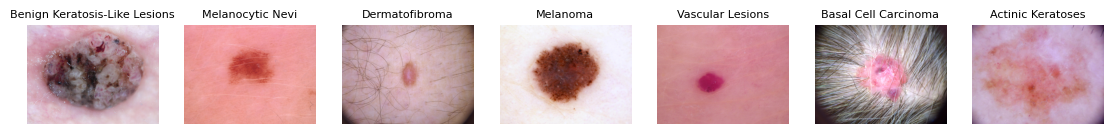

In [36]:
img_per_class = {}

for c in classes:
  files = df_metadata[df_metadata['diagnosis'] == c]['image_path']
  index = np.random.randint(len(files))
  img_per_class[c] = files.iloc[index]

fig=plt.figure(figsize=(20, 20))
for i, (k, v) in enumerate(img_per_class.items()):
    fig.add_subplot(10, 10, i+1)
    plt.axis('off')
    img = Image.open(v)
    plt.title(k, fontsize=8);
    plt.imshow(img)
plt.show()

Se visualiza una imagen aleatoria por cada clase.

# Balanceo de clases, 'Data Augmentation'

Como se observó en el análisis exploratorio, el conjunto de datos tiene un desbalance significativo en las clases, siendo ‘Melanocytic Nevi’ la clase mayoritaria con 6705 imágenes.

Para abordar este problema, se va a utilizar la técnica de ‘data augmentation’, que permite aumentar artificialmente el tamaño del conjunto de entrenamiento generando variaciones de las imágenes existentes.


Existen varias bibliotecas especializadas para ‘data augmentarion’, como ‘Augmentor’, ‘Albumentations’, ‘Imgaug’, y ‘AutoAugment (DeepAugment)’. Se va a optar por utilizar/adaptar una solución publicada en Kaggle por Angela Rentsi, que utiliza la biblioteca ‘Imgaug’ para crear un conjunto de datos balanceado antes del entrenamiento.

```
!pip install imgaug opencv-python
```

```
import os
import pandas as pd
from skimage import io
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

# Define your augmentation pipeline
aug_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flip with probability 0.5
    iaa.Flipud(0.2),  # vertical flip with probability 0.2
    iaa.Crop(percent=(0, 0.1)),  # random crop with a ratio of length and width of 0.9 to 1.0
    iaa.Affine(rotate=(-20, 20), shear=(-10, 10), mode='edge'),  # random rotation and shear, fill with edge pixels
    iaa.MultiplyBrightness((0.8, 1.2)),  # change brightness
    iaa.GaussianBlur(sigma=(0, 1.0)),  # Gaussian blur
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # additive Gaussian noise
    iaa.ContrastNormalization((0.8, 1.2)),  # change contrast
    iaa.Multiply((0.8, 1.2)),  # change brightness
    iaa.Grayscale(alpha=(0.0, 1.0)),  # convert to grayscale with probability
    iaa.CoarseDropout(0.02, size_percent=0.05, per_channel=False),  # random dropout
    iaa.CLAHE(clip_limit=(1, 4))  # apply CLAHE
])

# Directory to save augmented images
augmented_images_dir = '/content/drive/MyDrive/skin-cancer/data/HAM10000_augmented'
os.makedirs(augmented_images_dir, exist_ok=True)

# Get the class counts
class_counts = df_metadata['diagnosis'].value_counts()
max_count = class_counts.max()

# Create an empty list to hold the balanced samples
balanced_samples = []

# Oversample each class with augmentation to match the class with the maximum count
for label in class_counts.index:
    class_subset = df_metadata[df_metadata['diagnosis'] == label]

    if len(class_subset) < max_count:
        n_augmentations = max_count - len(class_subset)
        augmented_samples = []
        for i in range(n_augmentations):
            sample = class_subset.sample(n=1, random_state=42).iloc[0]
            img_path = sample['image_path']
            img = io.imread(img_path)
            augmented_image = aug_pipeline(image=img)

            # Save the augmented image
            augmented_image_path = os.path.join(augmented_images_dir, f'{label}_augmented_{i}.jpg')
            io.imsave(augmented_image_path, augmented_image)

            # Store the augmented image and update the image path
            augmented_sample = sample.copy()
            augmented_sample['image_path'] = augmented_image_path
            augmented_samples.append(augmented_sample)

        augmented_df = pd.DataFrame(augmented_samples)
        class_oversampled = pd.concat([class_subset, augmented_df], ignore_index=True)
    else:
        class_oversampled = class_subset

    balanced_samples.append(class_oversampled)

# Combine all oversampled classes into a single DataFrame
balanced_dataset = pd.concat(balanced_samples).reset_index(drop=True)

balanced_dataset.to_csv('/content/drive/MyDrive/skin-cancer/HAM10000_metadata_augmented')

print("Dataset balanced successfully!")
```





En esta solución, el pipeline de generación de imágenes incluye las siguientes transformaciones:
1.	Giro horizontal con probabilidad del 50%.
2.	Giro vertical con probabilidad del 20%.
3.	Recorte aleatorio con una relación de largo y ancho de 0.9 a 1.0.
4.	Rotación y corte aleatorios, rellenando con píxeles de borde.
5.	Ajuste de brillo.
6.	Desenfoque gaussiano.
7.	Ruido gaussiano aditivo.
8.	Ajuste de contraste.
9.	Conversión a una escala de grises con una probabilidad definida.
10.	Pérdida aleatoria de píxeles.
11.	Aplicación de CLAHE (Ecualización de Histograma adaptativa Contrastada).


In [ ]:
balanced_dataset = pd.read_csv('/content/drive/MyDrive/skin-cancer/HAM10000_metadata_augmented')

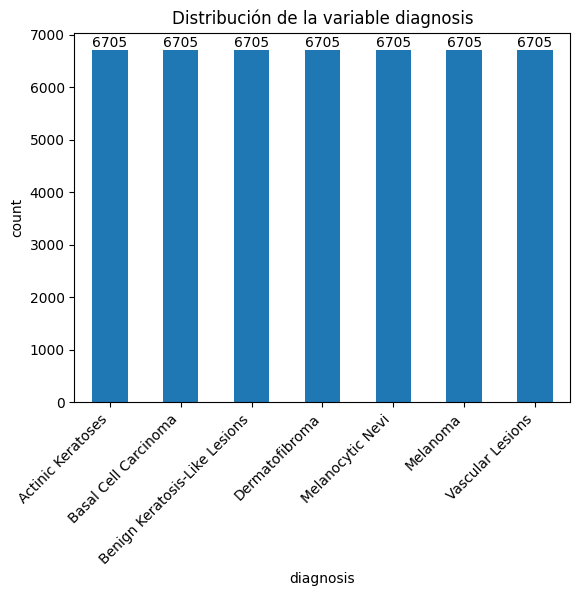

In [ ]:
ax =(
    balanced_dataset
    .groupby('diagnosis').size()
    .plot(kind='bar', title='Distribución de la variable diagnosis')
)

for container in ax.containers:
    ax.bar_label(container)

plt.ylabel('count')
plt.xticks(rotation=45, ha='right');

Tras aplicar 'data augmentation', se logra balancear todas las clases con el mismo número de imágenes que la clase mayoritaria.